# Word2Vec


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA 

%matplotlib inline

In [ ]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

In [ ]:

def get_word_vector(word_idx):
    x = torch.zeros(data.num_tokens()).float()
    x[word_idx] = 1.0
    return x




In [ ]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_contexts = num_contexts
        self.samples = []
        self.num_tokens = self.data.num_tokens()

    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        self.samples = []
        for _ in range(self.num_contexts):
            center_word, other_words = self.data.get_random_context(5)
            word_index = self.data.index_by_token[f'{center_word}']
            for target in other_words:
                target_index = self.data.index_by_token[f'{target}']
                self.samples.append([word_index, target_index])
        return self.samples


    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.samples)


    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        input_vector = get_word_vector([self.samples[index][0]])
        return input_vector, self.samples[index][1]
dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
print(len(dataset))
input_vector, target = dataset[3]

print("Sample - input: %s , Target - output: %u"% (input_vector, target)) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

24
Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]) , Target - output: 9758


In [ ]:

dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

wordvec_dim = 200


nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)
for param in nn_model.parameters():
    param.requires_grad = True


In [ ]:
device = torch.device("cuda:0")

In [ ]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    softmax = nn.Softmax(dim=1)
    loss_history = []
    train_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        dataset.generate_dataset() # Regenerate dataset every epoch
        
        running_loss = 0
        running_acc = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            preds = nn_model(inputs)
            loss_value = loss(preds, targets)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            running_loss += loss_value
           
            _, indices = torch.max(preds, 1)
            correct_samples += torch.sum(indices == targets)
            total_samples += targets.shape[0]
        
        ave_loss = running_loss / i_step
        train_accuracy = float(correct_samples) / total_samples
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

In [ ]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    return list(nn_model.parameters())[0].permute(1, 0), list(nn_model.parameters())[0].permute(1, 0)
untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [ ]:

optimizer = optim.Adam(nn_model.parameters(), lr=1.0e-3, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=300)

loss_history, train_history = train_model(nn_model.to(device), dataset, train_loader, optimizer, scheduler, 200)

Epoch 0, Average loss: 9.900005, Train accuracy: 0.020015
Epoch 1, Average loss: 9.742133, Train accuracy: 0.007407
Epoch 2, Average loss: 9.567912, Train accuracy: 0.005917
Epoch 3, Average loss: 9.469154, Train accuracy: 0.006960
Epoch 4, Average loss: 9.400890, Train accuracy: 0.009048
Epoch 5, Average loss: 9.350132, Train accuracy: 0.011664
Epoch 6, Average loss: 9.268407, Train accuracy: 0.014373
Epoch 7, Average loss: 9.191470, Train accuracy: 0.017096
Epoch 8, Average loss: 9.103164, Train accuracy: 0.019388
Epoch 9, Average loss: 8.999052, Train accuracy: 0.024696
Epoch 10, Average loss: 8.889446, Train accuracy: 0.029840
Epoch 11, Average loss: 8.753926, Train accuracy: 0.034655
Epoch 12, Average loss: 8.618404, Train accuracy: 0.039350
Epoch 13, Average loss: 8.455868, Train accuracy: 0.045395
Epoch 14, Average loss: 8.318628, Train accuracy: 0.048877
Epoch 15, Average loss: 8.137229, Train accuracy: 0.055738
Epoch 16, Average loss: 7.978880, Train accuracy: 0.060242
Epoch 1

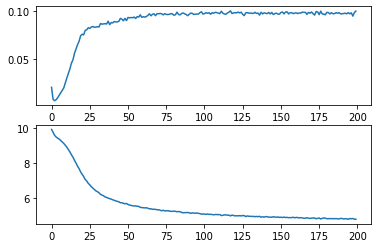

In [ ]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

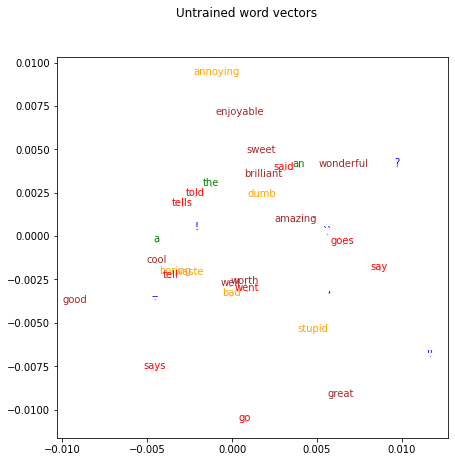

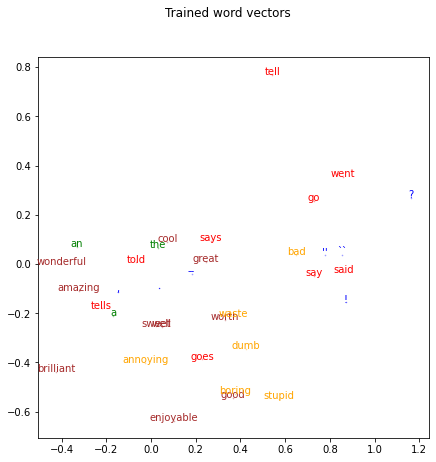

In [ ]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.cpu().detach().numpy())

   
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")